In [1]:
%%time
# Import necessary Libraries
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import pickle # used to store cleaned data
import numpy.ma as ma # masking for numpy Arrays
boolVal = False
attedDataName = '../../project_data/Overlapping_GenesMR.p'
bioGRIDfileName = '../../project_data/BioGRID_with_ATTEDMR.p'
wholeAttedDataName = '../../project_data/AllAttedGenesMR.p'
AbcLtpDataName = '../../project_data/AbcLtpMRData.p'

if boolVal:
    # Reading in BioGRID as DataFrame
    bioGRID_file = '../../project_data/BIOGRID-ORGANISM-Arabidopsis_thaliana_Columbia-3.5.181.tab2.txt'
    bioGRID_DF = pd.read_csv(bioGRID_file, sep = '\t')
    # Simplified DataFrame to only include interactions
    simplebGRID = bioGRID_DF[['Entrez Gene Interactor A','Entrez Gene Interactor B']]
    # Identifying Organisms Present in BioGRID
    OrganismTypesA = list(bioGRID_DF['Organism Interactor A'].unique())
    OrganismTypesB = list(bioGRID_DF['Organism Interactor B'].unique())
    OrganismTypesA.sort()
    OrganismTypesB.sort()
    OrganismTypes = list(set([*OrganismTypesA, *OrganismTypesB]))
    OrganismTypes.sort()
    # Use NCBI's Taxonomy Name/ID Status Report - Plug in OrganismTypes and get .txt
    organismIDs = pd.read_csv('../../project_data/tax_report.txt', sep = '\t')
    organismIDs.drop(columns = ['|','|.1','|.2', 'code', 'primary taxid'],inplace = True)
    # Categorize into different subsets based on organism ID. We know '3702' is Arabidopsis
    mask1 = bioGRID_DF['Organism Interactor A'] == 3702
    mask2 = bioGRID_DF['Organism Interactor B'] == 3702
    onlyArabDF = bioGRID_DF[mask1& mask2]
    oneArabDF = bioGRID_DF[~mask1|~mask2]
    noArabDF = bioGRID_DF[~mask1 & ~mask2]
    # Get list of genes so I can import the necessary ATTED Data. Note that the ATTED data has a text file by Entrez gene ID
    # WholeData:
    wholeGenesA = list(bioGRID_DF['Entrez Gene Interactor A'].unique())
    wholeGenesB = list(bioGRID_DF['Entrez Gene Interactor B'].unique())
    wholeGenesA.sort()
    wholeGenesB.sort()
    wholeGenes = list(set([*wholeGenesA, *wholeGenesB]))
    wholeGenes.sort()
    # Only Arabidopsis Subset
    ArabGenesA = list(onlyArabDF['Entrez Gene Interactor A'].unique())
    ArabGenesB = list(onlyArabDF['Entrez Gene Interactor B'].unique())
    ArabGenesA.sort()
    ArabGenesB.sort()
    ArabGenes = list(set([*ArabGenesA, *ArabGenesB]))
    ArabGenes.sort()
    # Read in only the Overlapping Genes
    # Get a list of all genes in ATTED
    atted = pd.read_csv('../../project_data/Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d/814630', sep = '\t', header = None)
    atted = atted.sort_values(by = 0)
    a1 = np.array(atted[0])
    attedGenes = list(a1)
    # Reading in of Overlapping Genes
    attedpath = 'C:\\Users\\ysman\\OneDrive\\Desktop\\project_data\\Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d\\'
    overlapGenes = []
    for i in range (len(wholeGenes)):
        if os.path.exists(attedpath+'{}'.format(wholeGenes[i])):
            overlapGenes.append(wholeGenes[i])
    DF = {0:attedGenes}
    for x in overlapGenes:
        tempAtted = pd.read_csv('../../project_data/Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d/{}'.format(x), sep = '\t', header= None)
        tempAtted = tempAtted.sort_values(by = 0)
        templist = list(tempAtted[1])
        DF.update({x:templist})
    attedData = pd.DataFrame(DF,dtype='float64')
    attedData = attedData.astype({0:'int'})
    attedData = attedData.set_index(0)
    pickle.dump(attedData, open(attedDataName, 'wb'))
    # Add ATTED MR Values to BioGRID
    genesGRID = simplebGRID.loc[:]
    genesGRID['MR']=np.zeros(len(genesGRID))
    # for gA,gB in zip(toyGRID.iloc[:,0],toyGRID.iloc[:,1]): is a way to iterate through 2 cols at once
    for i in range(genesGRID.shape[0]):
        gA = genesGRID.loc[i,'Entrez Gene Interactor A']
        gB = genesGRID.loc[i,'Entrez Gene Interactor B']
        if (gA in attedData.columns) and (gB in attedData.columns): # checks if both genes are part of the overlapping set
            mr = attedData.loc[gA,gB]
            genesGRID.loc[i,'MR'] = mr
        else:
            genesGRID.loc[i,'MR'] = np.nan
    pickle.dump(genesGRID, open(bioGRIDfileName, 'wb'))
    # Create a DataFrame of all MR values in the ATTED data
    aDF = {0:attedGenes}
    for x in attedGenes:
        tempAtted = pd.read_csv('../../project_data/Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d/{}'.format(x), sep = '\t', header= None)
        tempAtted = tempAtted.sort_values(by = 0)
        templist = list(tempAtted[1])
        aDF.update({x:templist})
    wholeAttedData = pd.DataFrame(aDF,dtype='float64')
    wholeAttedData = wholeAttedData.astype({0:'int'})
    wholeAttedData = wholeAttedData.set_index(0)
    pickle.dump(wholeAttedData, open(wholeAttedDataName, 'wb'))
    
    boolVal = False
else:
    # Load data using pickle
    attedData = pickle.load(open(attedDataName, 'rb'))
    genesGRID = pickle.load(open(bioGRIDfileName, 'rb'))
    wholeAttedData = pickle.load((open(wholeAttedDataName, 'rb')))
# Initializes Networkx Graph
genesG = nx.Graph()
# Adds edges for each interaction
for i in range(genesGRID.shape[0]):
    genesG.add_edge(genesGRID['Entrez Gene Interactor A'].loc[i], genesGRID['Entrez Gene Interactor B'].loc[i], weight = genesGRID['MR'].loc[i])

def nonConvertible(orig,trans): 
    '''
    Checks if all orginal values are in new list of values 
    and returns the ones that aren't
    Inputs: List of original values, list of new values
    Output: List of all original values that are not in the new value list
    ''' 
    nc = []
    for i in range(len(orig)):
        if orig[i] not in trans:
            nc.append(orig[i])
        else:
            continue
    return nc

def existing(lst, reference): 
    '''
    Checks if items of lst are in reference, returns a list of existing values
    Inputs: List to check, list to cross-reference with
    Output: List of all values that also exist in the reference list.
    ''' 
    exists = [] # stores the existing values
    NE = [] # stores the non-existing values
    for x in lst:
        if x in reference:
            exists.append(x)
        else:
            NE.append(x)
    return exists, NE

def ShortestDistances(Graph,grpA,grpB,dataFrame = True): #using function caused Kernel to crash due to memory
    '''
    Finds the shortest distances in a graph between all members of group 1 
    and all members of group 2 and stores into a dict.
    Inputs: Graph to scan, list of group A nodes, list of group B nodes
    Output: Returns a pandas dataFrame with group A as columns and group B as rows 
            and the shortest-distance as the values. 
            Else, returns a dict with group A as keys and a list of shortest distances 
            as values (size of list is the length of group B)
    '''
    graphGenes = list(Graph.nodes)
    abc, Uabc = existing(grpA,graphGenes)
    ltp, Ultp = existing(grpB,graphGenes)
    DF={0:ltp}
    for x in abc:
        valList = []
        for y in ltp:
            if (x in graphGenes) and (y in graphGenes): # checks if both genes are part of the overlapping set
                val = nx.astar_path_length(Graph, x,y)
            else:
                val = np.nan
            valList.append(val)
        DF.update({x:valList})
    if dataFrame:
        Data = pd.DataFrame(DF,dtype='float64')
        Data = Data.astype({0:'int'})
        Data = Data.set_index(0)
        return Data
    else:
        return DF
# option: filter out nodes with 1 connection
# store as a dictionary, dict: 
def simplifyGraph(grpA, grpB, Graph, kdeg):
    '''
    Gathers all nodes within kdeg degrees of separation from the given groups.
    Inputs: list of group A nodes, list of group B nodes, graph to simplify, int representing
            the degree of seperation from the key nodes allow.
    Output: subgraph of inputted graph as well as dictionary with each node in the new graph as key
            and # of neighboring nodes in group A, # of neighboring nodes in group B, and 
            list of all neighboring nodes.
    '''
    keyGenes = sorted(set([*grpA,*grpB]))
    i = kdeg
    while i >0:
        # Stores neighbors at each key gene
        neighbors = []
        # Loops through all key genes 
        for gene in keyGenes:
            nodes = [n for n in Graph.neighbors(gene)]
            neighbors.append(nodes)
        neighbors.append(keyGenes)
        neighbors = [item for sublist in neighbors for item in sublist]
        keyGenes = sorted(set(neighbors))
        i-=1
    # Creates subgraph
    newGraph = Graph.subgraph(keyGenes)
    # Iterates through the new nodes and checks if neighbors are in either group A or B
    geneDict = {}
    for gene in newGraph.nodes:
        nodes = [n for n in newGraph.neighbors(gene)]
        grpACount = 0
        grpBCount = 0
        for ngene in nodes:
            if ngene in grpA:
                grpACount +=1
            elif ngene in grpB:
                grpBCount +=1
        geneDict[gene] = (grpACount,grpBCount, nodes)
    return newGraph, geneDict

# Read In Data 
ABC_trans = pd.read_csv('../data/convABC_Genes.txt', sep = '\t')
ABC_trans = ABC_trans.rename(columns = {'From':'TAIR_ID','To':'ENTREZ_ID'})
ABC_orig = pd.read_excel('../data/ABC_Genes.xls', sheet_name = 'Sheet2')
abcAT = sorted(set(list(ABC_trans['TAIR_ID'])))
abcEntrez = sorted(set(list(ABC_trans['ENTREZ_ID'])))
abcAT_orig = sorted(set(list(ABC_orig['TAIR_ID'])))
abc_NC  = nonConvertible(abcAT_orig,abcAT)
LTP_trans = pd.read_csv('../data/convLTP_Genes.txt', sep = '\t')
LTP_trans = LTP_trans.rename(columns = {'From':'TAIR_ID','To':'ENTREZ_ID'})
LTP_orig = pd.read_excel('../data/LTP_Genes.xlsx', sheet_name = 'Sheet1')
ltpAT = sorted(set(list(LTP_trans['TAIR_ID'])))
ltpEntrez = sorted(set(list(LTP_trans['ENTREZ_ID'])))
ltpAT_orig = sorted(set(list(LTP_orig['TAIR_ID'])))
ltp_NC  = nonConvertible(ltpAT_orig,ltpAT)
abc, Uabc = existing(abcEntrez,genesG.nodes)
ltp, Ultp = existing(ltpEntrez,genesG.nodes)

# Create MR values for all ABC and LTP genes in ATTED set.
newBool = False
attedAbc, attedUabc = existing(abcEntrez, wholeAttedData.columns)
attedLtp, attedUltp = existing(ltpEntrez, wholeAttedData.columns)
if newBool:
    mrDF = {0: attedLtp}
    for abc in attedAbc:
        tempMRs = []
        for ltp in attedLtp:
            if (abc in wholeAttedData.columns) and (ltp in wholeAttedData.columns):
                tempMR = wholeAttedData.loc[abc,ltp]
            tempMRs.append(tempMR)
        mrDF[abc] = tempMRs
    AbcLtpData = pd.DataFrame(mrDF,dtype='float64')
    AbcLtpData = AbcLtpData.astype({0:'int'})
    AbcLtpData = AbcLtpData.set_index(0)
    pickle.dump(AbcLtpData, open(AbcLtpDataName, 'wb'))
    newBool = False
else:
    AbcLtpData = pickle.load((open(AbcLtpDataName, 'rb')))

# Run Shortest Path & store as pickle files
simpleShortDistFileName = '../../project_data/simplifiedShortestDistances.p'
shortDistFileName = '../../project_data/shortestDistances.p'
'''
simpleG, simpleGDict = simplifyGraph(abc,ltp, genesG,1)
simple_abc_ltp_shortDist = ShortestDistances(genesG,abcEntrez,ltpEntrez, True)
pickle.dump(abc_ltp_shortDist, open(shortDistFileName, 'wb'))
simple_abc_ltp_shortDist = ShortestDistances(simpleG,abcEntrez,ltpEntrez, True)
pickle.dump(simple_abc_ltp_shortDist, open(simpleShortDistFileName, 'wb'))
'''
print(f'ATTED-compatible ABC Genes: {len(attedAbc)}/{len(abcEntrez)}')
print(f'ATTED-compatible LTP Genes: {len(attedLtp)}/{len(ltpEntrez)}')

ATTED-compatible ABC Genes: 103/129
ATTED-compatible LTP Genes: 55/85
Wall time: 23.5 s


In [6]:
len(set(genesG.edges()))

48981

In [177]:
def GetTopGenes(cutoff, printbool =False,attedAbc = attedAbc, attedLtp = attedLtp, wholeAttedData=wholeAttedData):
    '''
    Gathers all ABC/LTP gene interactions with MR values less than cutoff.
    Inputs: MR cutoff, list of Atted-compatible ABC genes, list of Atted-compatible LTP genes,
            ATTED Co-expression MR matrix.
    Output: list of tuples for each ABC/LTP interaction and dict with ABC genes as keys
            and LTP genes as values, and list of unique genes.
    '''
    closeGenes = []
    topGenes = {}
    for abc in attedAbc:
        closeLTPs = []
        for ltp in attedLtp:
            if wholeAttedData.loc[abc,ltp]<cutoff:
                closeGenes.append((abc,ltp))
                closeLTPs.append((ltp,wholeAttedData.loc[abc,ltp]))
        topGenes[abc] = closeLTPs
    numInter = len(closeGenes)
    uniqueGenes = sorted(set([gene for genes in closeGenes for gene in genes]))
    numUgenes = len(uniqueGenes)
    if printbool:
        print(f'There are {numInter} interactions when applying a cutoff of less than {np.round(cutoff,2)}.')
        print(f'There are {numUgenes} unique genes interacting with the given cutoff of less than {np.round(cutoff,2)}.')
    return closeGenes,topGenes,uniqueGenes
def GetTopNGenes(N):
    '''
    Gathers top ABC/LTP gene interactions with a cutoff of N unique genes.
    Inputs: number of interactions.
    Output: list of tuples for each ABC/LTP interaction and dict with ABC genes as keys
            and LTP genes as values, and list of unique genes.
    '''
    n_genes = 0
    cutoff = 0
    uniqueGenes = 0
    while n_genes<N:
        closeGenes,topGenes,uniqueGenes = GetTopGenes(cutoff)
        n_genes = len(uniqueGenes)
        cutoff +=5
    cutoff -=5
    if len(uniqueGenes) ==N:
        return GetTopGenes(cutoff, True)
    else:
        while n_genes>N:
            closeGenes,topGenes,uniqueGenes = GetTopGenes(cutoff)
            n_genes = len(uniqueGenes)
            cutoff -=.1
        cutoff +=.1
        return GetTopGenes(cutoff,True)
def GetTopNInter(N):
    '''
    Gathers top ABC/LTP gene interactions with a cutoff of N unique genes.
    Inputs: number of interactions.
    Output: list of tuples for each ABC/LTP interaction and dict with ABC genes as keys
            and LTP genes as values, and list of unique genes.
    '''
    n_inter = 0
    cutoff = 0
    closeGenes = 0
    while n_inter<N:
        closeGenes,topGenes,uniqueGenes = GetTopGenes(cutoff)
        n_inter = len(closeGenes)
        cutoff +=5
    cutoff -=5
    if len(closeGenes) ==N:
        return GetTopGenes(cutoff, True)
    else:
        while n_inter>N:
            closeGenes,topGenes,uniqueGenes = GetTopGenes(cutoff)
            n_inter = len(closeGenes)
            cutoff -=.1
        cutoff +=.1
        return GetTopGenes(cutoff,True)

In [606]:
closeGenes,topGenes,uniqueGenes = GetTopGenes(100,True)

There are 75 interactions when applying a cutoff of less than 100.
There are 52 unique genes interacting with the given cutoff of less than 100.


In [417]:
closeGenes,topGenes,uniqueGenes = GetTopGenes(max(AbcLtpData.max())+1,True)
ABCall = [genes[0] for genes in closeGenes]
LTPall = [genes[1] for genes in closeGenes]
All_MR_vals= [wholeAttedData.loc[abc,ltp] for abc,ltp in zip(ABCall,LTPall)]

closeGenesU,topGenesU,uniqueGenesU = GetTopNGenes(158)

There are 5665 interactions when applying a cutoff of less than 20812.77.
There are 158 unique genes interacting with the given cutoff of less than 20812.77.
There are 1195 interactions when applying a cutoff of less than 3930.
There are 158 unique genes interacting with the given cutoff of less than 3930.


In [625]:
closeGenes50i,topGenes50i,uniqueGenes50i = GetTopNInter(50)
ABC50i = [genes[0] for genes in closeGenes50i]
LTP50i = [genes[1] for genes in closeGenes50i]
print(f'There are {len(set(ABC50i))} unique ABC genes and {len(set(LTP50i))} unique LTP genes.')
top50inter = {}
MR_vals = [wholeAttedData.loc[abc,ltp] for abc,ltp in zip(ABC50i,LTP50i)]
top50inter['ABC Entrez ID'] = ABC50i
top50inter['LTP Entrez ID'] = LTP50i
top50inter['MR'] = MR_vals
top50i = pd.DataFrame(top50inter)
top50i['ABC TAIR ID'] = [list(ABC_trans[ABC_trans['ENTREZ_ID']==gene]['TAIR_ID'])[0]for gene in ABC50i]
top50i['LTP TAIR ID'] = [list(LTP_trans[LTP_trans['ENTREZ_ID']==gene]['TAIR_ID'])[0]for gene in LTP50i]
top50i['ABC Gene Name'] = [list(ABC_trans[ABC_trans['ENTREZ_ID']==gene]['Gene Name'])[0]for gene in ABC50i]
top50i['LTP Gene Name'] = [list(LTP_trans[LTP_trans['ENTREZ_ID']==gene]['Gene Name'])[0]for gene in LTP50i]
top50i = top50i.sort_values(by = 'MR',ignore_index = True)
top50i

There are 50 interactions when applying a cutoff of less than 62.5.
There are 35 unique genes interacting with the given cutoff of less than 62.5.
There are 18 unique ABC genes and 17 unique LTP genes.


,ABC Entrez ID,LTP Entrez ID,MR,ABC TAIR ID,LTP TAIR ID,ABC Gene Name,LTP Gene Name
0,831202,831237,4.58,AT5G13580,AT5G13900,ABC-2 type transporter family protein(ABCG6),Bifunctional inhibitor/lipid-transfer protein/...
1,824675,837046,4.61,AT3G55090,AT1G05450,ABC-2 type transporter family protein(ABCG16),Bifunctional inhibitor/lipid-transfer protein/...
2,838363,839688,6.66,AT1G17840,AT1G27950,white-brown complex-like protein(ABCG11),glycosylphosphatidylinositol-anchored lipid pr...
3,818307,820024,7.03,AT2G37300,AT3G08770,transmembrane protein(ABCI16),lipid transfer protein 6(LTP6)
4,841761,837046,7.26,AT1G53270,AT1G05450,ABC-2 type transporter family protein(ABCG10),Bifunctional inhibitor/lipid-transfer protein/...
5,832061,831237,9.15,AT5G19410,AT5G13900,ABC-2 type transporter family protein(ABCG23),Bifunctional inhibitor/lipid-transfer protein/...
6,831202,819426,9.94,AT5G13580,AT2G48140,ABC-2 type transporter family protein(ABCG6),Bifunctional inhibitor/lipid-transfer protein/...
7,828702,839688,10.41,AT4G25960,AT1G27950,P-glycoprotein 2(ABCB2),glycosylphosphatidylinositol-anchored lipid pr...
8,838363,823481,11.33,AT1G17840,AT3G43720,white-brown complex-like protein(ABCG11),Bifunctional inhibitor/lipid-transfer protein/...
9,824675,831237,12.17,AT3G55090,AT5G13900,ABC-2 type transporter family protein(ABCG16),Bifunctional inhibitor/lipid-transfer protein/...


In [385]:
(set(top50i['ABC Gene Name']))

{'ABC transporter family protein(ABCG28)',
 'ABC-2 type transporter family protein(ABCG1)',
 'ABC-2 type transporter family protein(ABCG10)',
 'ABC-2 type transporter family protein(ABCG12)',
 'ABC-2 type transporter family protein(ABCG13)',
 'ABC-2 type transporter family protein(ABCG16)',
 'ABC-2 type transporter family protein(ABCG18)',
 'ABC-2 type transporter family protein(ABCG2)',
 'ABC-2 type transporter family protein(ABCG20)',
 'ABC-2 type transporter family protein(ABCG23)',
 'ABC-2 type transporter family protein(ABCG6)',
 'ABC2 homolog 6(ABCA7)',
 'P-glycoprotein 2(ABCB2)',
 'multidrug resistance-associated protein 7(ABCC7)',
 'pleiotropic drug resistance 1(ABCG29)',
 'pleiotropic drug resistance 4(ABCG32)',
 'transmembrane protein(ABCI16)',
 'white-brown complex-like protein(ABCG11)'}

In [386]:
set(top50i['LTP Gene Name'])

{'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT1G05450)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT1G36150)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT1G55260)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT2G18370)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT2G44300)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT2G48130)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT3G22620)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT3G58550)',
 'Bifunctional inhibitor/lipid-transfer protein/seed storage 2S albumin superfamily protein(AT5G13900)',
 'Bifunctional inhibitor/lipid-transfer protein/seed st

In [422]:
%%time
# FIND GOOD CUTOFF
num_IntersAll = []
num_UgenesAll = []
num_UabcAll = []
num_UltpAll = []
cutoffsAll = np.arange(0,20812.77+10,10)
for cutoff in cutoffsAll:
    closeGenes,topGenes,uniqueGenes = GetTopGenes(cutoff)
    num_IntersAll.append(len(closeGenes))
    num_UgenesAll.append(len(uniqueGenes))
    num_UabcAll.append(len(set([genes[0] for genes in closeGenes])))
    num_UltpAll.append(len(set([genes[1] for genes in closeGenes])))
    

Wall time: 2min 9s


In [418]:
%%time
# FIND GOOD CUTOFF
num_Inters = []
num_Ugenes = []
num_Uabc = []
num_Ultp = []
cutoffs = np.arange(0,100,.1)
for cutoff in cutoffs:
    closeGenes,topGenes,uniqueGenes = GetTopGenes(cutoff)
    num_Inters.append(len(closeGenes))
    num_Ugenes.append(len(uniqueGenes))
    num_Uabc.append(len(set([genes[0] for genes in closeGenes])))
    num_Ultp.append(len(set([genes[1] for genes in closeGenes])))

Wall time: 52.3 s


In [555]:
parAll = np.polyfit(cutoffsAll, num_IntersAll,1)
modelAll = np.poly1d(parAll)
yAll = model(cutoffsAll)
print(f'Slope is {np.round(parAll[0],2)} and y-intercept is {np.round(parAll[1],2)}.')
Interpar = np.polyfit(cutoffs, num_Inters,1)
Intermodel = np.poly1d(Interpar)
InterY = Intermodel(cutoffs)
print(f'Slope is {np.round(Interpar[0],2)} and y-intercept is {np.round(Interpar[1],2)}.')

Slope is 0.26 and y-intercept is 97.39.
Slope is 0.75 and y-intercept is 4.3.


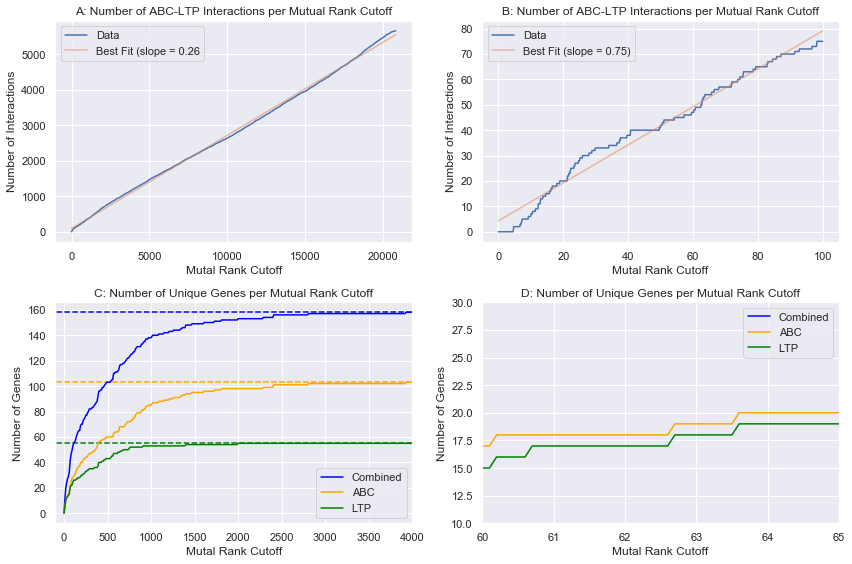

In [629]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(cutoffsAll, num_IntersAll, label ='Data')
axs[0,0].plot(cutoffsAll, yAll, alpha =0.5, label = f'Best Fit (slope = {np.round(parAll[0],2)}')
axs[0,0].set_title('A: Number of ABC-LTP Interactions per Mutual Rank Cutoff')
axs[0,0].set_xlabel('Mutal Rank Cutoff')
axs[0,0].set_ylabel('Number of Interactions')
axs[0,0].legend()

axs[0,1].plot(cutoffs, num_Inters, label ='Data')
axs[0,1].plot(cutoffs, InterY, alpha =0.5, label = f'Best Fit (slope = {np.round(Interpar[0],2)})')
axs[0,1].set_title('B: Number of ABC-LTP Interactions per Mutual Rank Cutoff')
axs[0,1].set_xlabel('Mutal Rank Cutoff')
axs[0,1].set_ylabel('Number of Interactions')
axs[0,1].legend()

axs[1,0].plot(cutoffsAll, np.array(num_UgenesAll), label = 'Combined',color= 'blue')
axs[1,0].plot(cutoffsAll, np.array(num_UabcAll), label = 'ABC',color= 'orange')
axs[1,0].plot(cutoffsAll, np.array(num_UltpAll), label = 'LTP', color ='green')
axs[1,0].hlines([158,103,55],-1000,20812.77, colors = ['blue','orange','green'], linestyles = 'dashed')
axs[1,0].set_title('C: Number of Unique Genes per Mutual Rank Cutoff')
axs[1,0].set_xlabel('Mutal Rank Cutoff')
axs[1,0].set_ylabel('Number of Genes')
axs[1,0].legend()
axs[1,0].set_xlim(-100,4000)

axs[1,1].plot(cutoffs, np.array(num_Ugenes), label = 'Combined',color= 'blue')
axs[1,1].plot(cutoffs, np.array(num_Uabc), label = 'ABC',color= 'orange')
axs[1,1].plot(cutoffs, np.array(num_Ultp), label = 'LTP', color ='green')
axs[1,1].hlines([158,103,55],-1000,20812.77, colors = ['blue','orange','green'], linestyles = 'dashed')
axs[1,1].set_title('D: Number of Unique Genes per Mutual Rank Cutoff')
axs[1,1].set_xlabel('Mutal Rank Cutoff')
axs[1,1].set_ylabel('Number of Genes')
axs[1,1].legend()
axs[1,1].set_xlim(60,65)
axs[1,1].set_ylim(10,30)
plt.tight_layout()
plt.savefig('../../CMSE_410_Images/LTP-ATPMRCutoffs.png')

# Preliminary Data Analysis
----

## ATTED

### Violin Plot

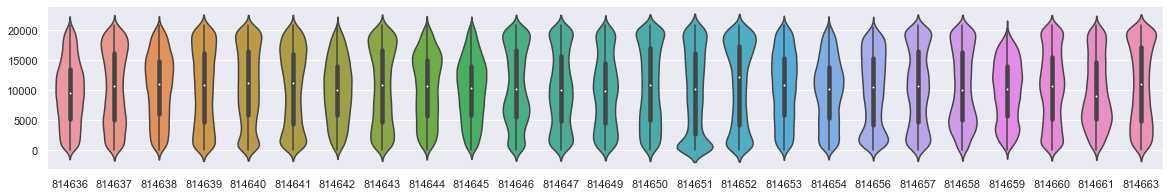

In [630]:
# Create Violin Plots
sns.set()
vioColnames= list(wholeAttedData.columns)
vioColnames = vioColnames[1:]
vioColnames
ax = plt.figure(figsize = (20,3))
ax =sns.violinplot(data = wholeAttedData[vioColnames[:25]])
plt.savefig('../../CMSE_410_Images/ViolinPlotsAtted.png')

### Mean, Median, Maximum Distributions

In [526]:
# Whole
AttedMaxes = sorted(wholeAttedData.max())
AttedMeans = sorted(wholeAttedData.mean())
AttedMeds = sorted(wholeAttedData.median())
print(min(AttedMaxes),max(AttedMaxes), np.mean(AttedMaxes),np.median(AttedMaxes))
print(min(AttedMeans),max(AttedMeans), np.mean(AttedMeans),np.median(AttedMeans))
print(min(AttedMeds),max(AttedMeds), np.mean(AttedMeds),np.median(AttedMeds))

# Overlapping
attedMaxes = sorted(attedData.max())
attedMeans = sorted(attedData.mean())
attedMeds = sorted(attedData.median())
print(min(attedMaxes),max(attedMaxes), np.mean(attedMaxes),np.median(attedMaxes))
print(min(attedMeans),max(attedMeans), np.mean(attedMeans),np.median(attedMeans))
print(min(attedMeds),max(attedMeds), np.mean(attedMeds),np.median(attedMeds))

18632.12 20818.0 20749.134657284212 20799.9
9303.554551611422 11570.467628608452 10360.996052788785 10363.804826840878
8026.39 13042.22 10583.594858062346 10527.91
19002.36 20818.0 20782.261336977564 20806.2
9333.037548873628 11517.991975599163 10497.958050937392 10556.599883760073
8203.1 13042.22 10759.117236077896 10804.69


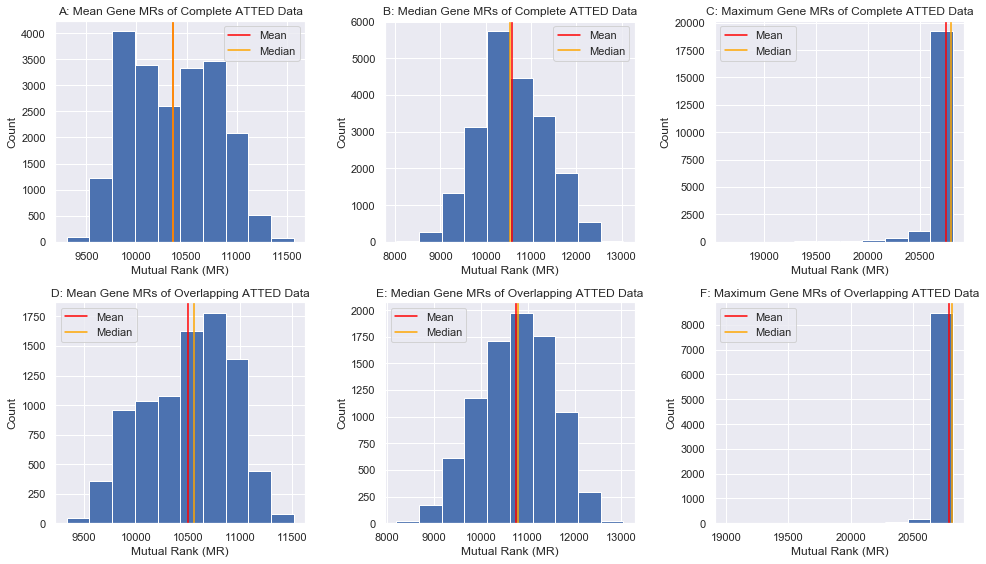

In [631]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
# Whole
axs[0,0].hist(AttedMeans)
axs[0,0].set_title('A: Mean Gene MRs of Complete ATTED Data')
axs[0,0].set_xlabel('Mutual Rank (MR)')
axs[0,0].set_ylabel('Count')
axs[0,0].axvline(np.mean(AttedMeans), color = 'Red', label ='Mean')
axs[0,0].axvline(np.median(AttedMeans), color = 'Orange', label ='Median')
axs[0,0].legend()

axs[0,1].hist(AttedMeds)
axs[0,1].set_title('B: Median Gene MRs of Complete ATTED Data')
axs[0,1].set_xlabel('Mutual Rank (MR)')
axs[0,1].set_ylabel('Count')
axs[0,1].axvline(np.mean(AttedMeds), color = 'Red', label ='Mean')
axs[0,1].axvline(np.median(AttedMeds), color = 'Orange', label ='Median')
axs[0,1].legend()

axs[0,2].hist(AttedMaxes)
axs[0,2].set_title('C: Maximum Gene MRs of Complete ATTED Data')
axs[0,2].set_xlabel('Mutual Rank (MR)')
axs[0,2].set_ylabel('Count')
axs[0,2].axvline(np.mean(AttedMaxes), color = 'Red', label ='Mean')
axs[0,2].axvline(np.median(AttedMaxes), color = 'Orange', label ='Median')
axs[0,2].legend()
#Overlapping
axs[1,0].hist(attedMeans)
axs[1,0].set_title('D: Mean Gene MRs of Overlapping ATTED Data')
axs[1,0].set_xlabel('Mutual Rank (MR)')
axs[1,0].set_ylabel('Count')
axs[1,0].axvline(np.mean(attedMeans), color = 'Red', label ='Mean')
axs[1,0].axvline(np.median(attedMeans), color = 'Orange', label ='Median')
axs[1,0].legend()

axs[1,1].hist(attedMeds)
axs[1,1].set_title('E: Median Gene MRs of Overlapping ATTED Data')
axs[1,1].set_xlabel('Mutual Rank (MR)')
axs[1,1].set_ylabel('Count')
axs[1,1].axvline(np.mean(attedMeds), color = 'Red', label ='Mean')
axs[1,1].axvline(np.median(attedMeds), color = 'Orange', label ='Median')
axs[1,1].legend()

axs[1,2].hist(attedMaxes)
axs[1,2].set_title('F: Maximum Gene MRs of Overlapping ATTED Data')
axs[1,2].set_xlabel('Mutual Rank (MR)')
axs[1,2].set_ylabel('Count')
axs[1,2].axvline(np.mean(attedMaxes), color = 'Red', label ='Mean')
axs[1,2].axvline(np.median(attedMaxes), color = 'Orange', label ='Median')
axs[1,2].legend()

plt.tight_layout()
plt.savefig('../../CMSE_410_Images/ATTEDPrelimDataAnalysis.png')

### Cumulative Mutual Rank

In [535]:
# Whole
# ATTED Degree-Rank based on MR
sumMR_WA = wholeAttedData.sum()
sumMR_WA = list(sumMR_WA)
rank_sumMR_WA = sorted(sumMR_WA, reverse = True)
# ATTED Degree-Count based on MR
binsize = 1000000
binMRW= (np.array(sumMR_WA)/binsize).astype('int')
attedCountW = collections.Counter(binMRW) 
MR_WA, cnt_WA = zip(*attedCountW.items())
n_binsW = len(MR_WA)

# Overlapping
# ATTED Degree-Rank based on MR
sumMR_A = attedData.sum()
sumMR_A = list(sumMR_A)
rank_sumMR_A = sorted(sumMR_A, reverse = True)
# ATTED Degree-Count based on MR
binsize = 1000000
binMR= (np.array(sumMR_A)/binsize).astype('int')
attedCount = collections.Counter(binMR) 
MR_A, cnt_A = zip(*attedCount.items())
n_bins = len(MR_A)

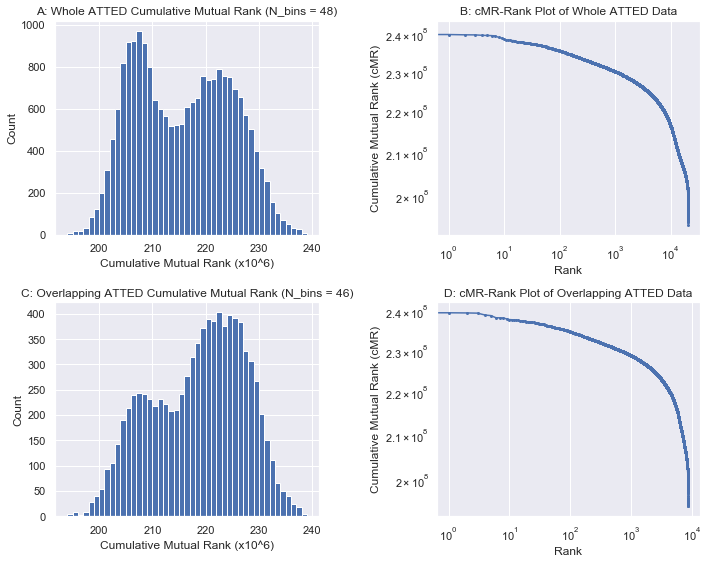

In [632]:
# Visualize MR distribution of ATTED
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# Whole
# Histogram
axs[0,0].hist(np.array(sumMR_WA)/1000000, bins = np.arange(194,240,1))
axs[0,0].set_title('A: Whole ATTED Cumulative Mutual Rank (N_bins = {})'.format(n_binsW))
axs[0,0].set_xlabel('Cumulative Mutual Rank (x10^{:.0f})'.format(np.log10(binsize)))
axs[0,0].set_ylabel('Count')
# Log-log Plot
axs[0,1].loglog(rank_sumMR_WA, 'b-', marker='o', markersize = 2)
axs[0,1].set_title("B: cMR-Rank Plot of Whole ATTED Data")
axs[0,1].set_ylabel("Cumulative Mutual Rank (cMR)")
axs[0,1].set_xlabel("Rank")
# Overlapping
# Histogram
axs[1,0].hist(np.array(sumMR_A)/1000000, bins = np.arange(194,240,1))
axs[1,0].set_title('C: Overlapping ATTED Cumulative Mutual Rank (N_bins = {})'.format(n_bins))
axs[1,0].set_xlabel('Cumulative Mutual Rank (x10^{:.0f})'.format(np.log10(binsize)))
axs[1,0].set_ylabel('Count')
# Log-log plot
axs[1,1].loglog(rank_sumMR_A, 'b-', marker='o', markersize = 2)
axs[1,1].set_title("D: cMR-Rank Plot of Overlapping ATTED Data")
axs[1,1].set_ylabel("Cumulative Mutual Rank (cMR)")
axs[1,1].set_xlabel("Rank")
plt.tight_layout()
plt.savefig('../../CMSE_410_Images/ATTEDCumMR.png')

## BioGRID

In [34]:
# BioGRID Degree-Rank based on MR
deg_Bio = [genesG.degree(gene) for gene in genesG.nodes] 
rank_deg_bio = sorted(deg_Bio, reverse = True)
# BioGRID Degree-Count
deg_Bio_count = collections.Counter(deg_Bio)
deg_B,cnt_B = zip(*deg_Bio_count.items())

In [585]:
len(deg_Bio)

10550

In [586]:
10550-2312

8238

In [588]:
a = ma.masked_less(deg_Bio, 50)
a = a.compressed()
len(a)

296

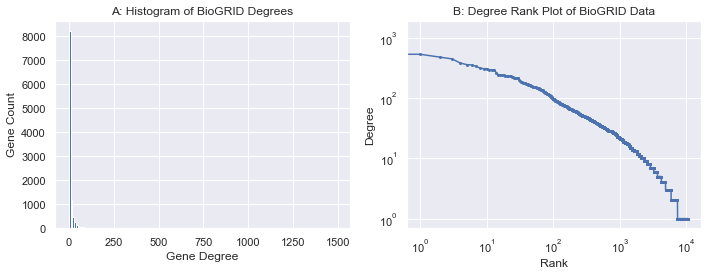

In [633]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.set_style('darkgrid')
axs[0].hist(deg_Bio, bins = np.arange(0,1500,10))
axs[0].set_title('A: Histogram of BioGRID Degrees')
axs[0].set_xlabel('Gene Degree')
axs[0].set_ylabel('Gene Count')

axs[1].loglog(rank_deg_bio, 'b-', marker='o', markersize = 2)
axs[1].set_title("B: Degree Rank Plot of BioGRID Data") 
axs[1].set_ylabel("Degree")
axs[1].set_xlabel("Rank")
plt.tight_layout()
plt.savefig('../../CMSE_410_Images/BioGRIDDegrees.png')

In [552]:
# BioGRID ABC Degree-Rank based on MR
deg_BioABC = [genesG.degree(gene) for gene in abc] 
rank_deg_bioABC = sorted(deg_BioABC, reverse = True)
# BioGRID ABC Degree-Count
deg_Bio_countABC = collections.Counter(deg_BioABC)
deg_BABC,cnt_BABC = zip(*deg_Bio_countABC.items())

# BioGRID LTP Degree-Rank based on MR
deg_BioLTP = [genesG.degree(gene) for gene in ltp] 
rank_deg_bioLTP = sorted(deg_BioLTP, reverse = True)
# BioGRID LTP Degree-Count
deg_Bio_countLTP = collections.Counter(deg_BioLTP)
deg_BLTP,cnt_BLTP = zip(*deg_Bio_countLTP.items())

# BioGRID Both ABC,LTP Degree-Rank based on MR
deg_BioB = [genesG.degree(gene) for gene in abc+ltp] 
rank_deg_bioB = sorted(deg_BioB, reverse = True)
# BioGRID Both ABC,LTP Degree-Count
deg_Bio_countB = collections.Counter(deg_BioB)
deg_BB,cnt_BB = zip(*deg_Bio_countB.items())

In [601]:
a = ma.masked_less(deg_BioLTP, 5)
a = a.compressed()
len(a)
a

array([ 5, 14])

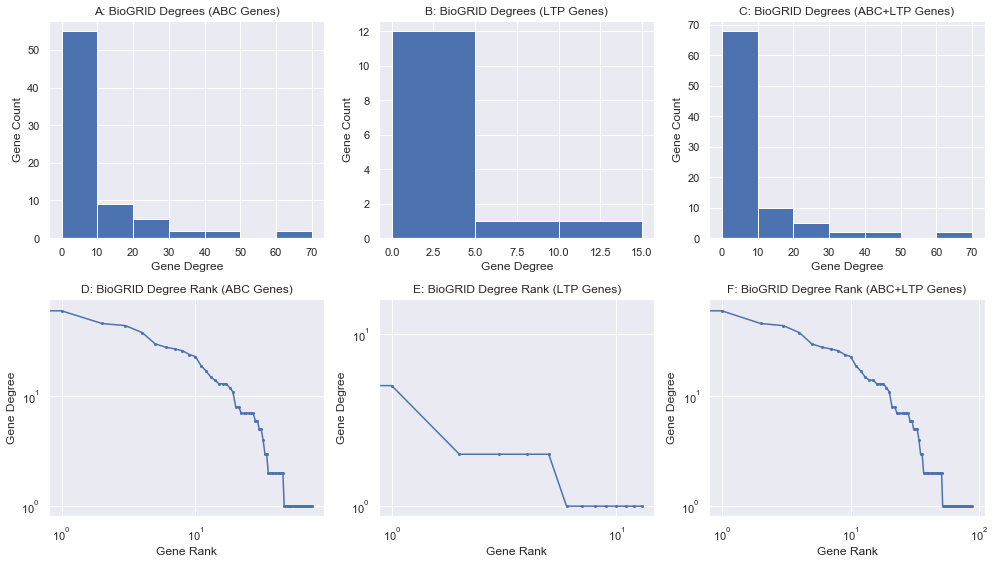

In [634]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
sns.set_style('darkgrid')
axs[0,0].hist(deg_BioABC, bins = np.arange(0,71,10))
axs[0,0].set_title('A: BioGRID Degrees (ABC Genes)')
axs[0,0].set_xlabel('Gene Degree')
axs[0,0].set_ylabel('Gene Count')
axs[0,1].hist(deg_BioLTP, bins = np.arange(0,20,5))
axs[0,1].set_title('B: BioGRID Degrees (LTP Genes)')
axs[0,1].set_xlabel('Gene Degree')
axs[0,1].set_ylabel('Gene Count')
axs[0,2].hist(deg_BioB, bins = np.arange(0,71,10))
axs[0,2].set_title('C: BioGRID Degrees (ABC+LTP Genes)')
axs[0,2].set_xlabel('Gene Degree')
axs[0,2].set_ylabel('Gene Count')

axs[1,0].loglog(rank_deg_bioABC, 'b-', marker='o', markersize = 2)
axs[1,0].set_title('D: BioGRID Degree Rank (ABC Genes)')
axs[1,0].set_xlabel('Gene Rank')
axs[1,0].set_ylabel('Gene Degree')
axs[1,1].loglog(rank_deg_bioLTP, 'b-', marker='o', markersize = 2)
axs[1,1].set_title('E: BioGRID Degree Rank (LTP Genes)')
axs[1,1].set_xlabel('Gene Rank')
axs[1,1].set_ylabel('Gene Degree')
axs[1,2].loglog(rank_deg_bioB, 'b-', marker='o', markersize = 2)
axs[1,2].set_title('F: BioGRID Degree Rank (ABC+LTP Genes)')
axs[1,2].set_xlabel('Gene Rank')
axs[1,2].set_ylabel('Gene Degree')
plt.tight_layout()
plt.savefig('../../CMSE_410_Images/LTP-ABCBioGRIDDegrees.png')

### Misc Plots

Text(0, 0.5, 'Gene Count')

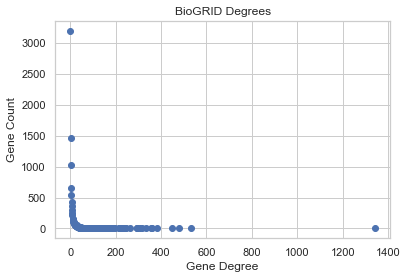

In [551]:
# Visualize degree distribution of BioGRID (psuedo bar plot)
sns.set_style('whitegrid')
sns.axes_style('ticks')
plt.scatter(deg_B,cnt_B)
plt.title('BioGRID Degrees')
plt.xlabel('Gene Degree')
plt.ylabel('Gene Count')

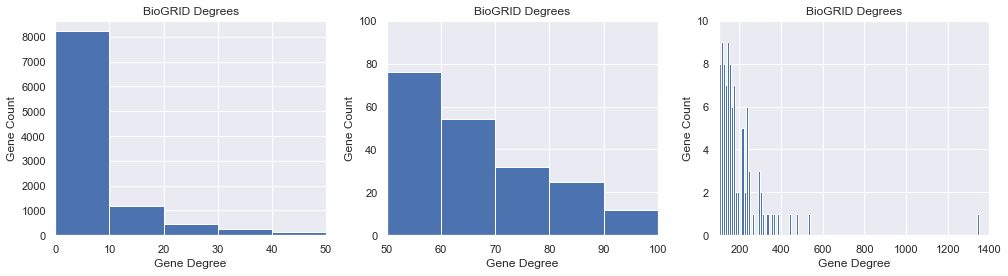

In [539]:
# Histogram Separated into 3 sections to see
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    axs[i].hist(deg_Bio, bins = np.arange(0,1500,10))
    axs[i].set_title('BioGRID Degrees')
    axs[i].set_xlabel('Gene Degree')
    axs[i].set_ylabel('Gene Count')
axs[0,1].set_xlim(0,50)
axs[1,].set_xlim(50,100)
axs[1].set_ylim(0,100)
axs[2].set_xlim(100,1400)
axs[2].set_ylim(0,10)
plt.tight_layout()

Text(0.5, 0, 'Rank')

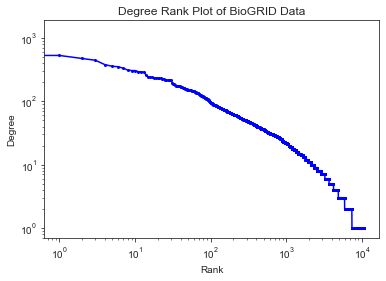

In [90]:
sns.set_style('ticks')
plt.loglog(rank_deg_bio, 'b-', marker='o', markersize = 2)
plt.title("Degree Rank Plot of BioGRID Data") 
plt.ylabel("Degree")
plt.xlabel("Rank")

In [97]:
# BioGRID ABC Degree-Rank based on MR
deg_BioABC = [genesG.degree(gene) for gene in abc] 
rank_deg_bioABC = sorted(deg_BioABC, reverse = True)
# BioGRID ABC Degree-Count
deg_Bio_countABC = collections.Counter(deg_BioABC)
deg_BABC,cnt_BABC = zip(*deg_Bio_countABC.items())

# BioGRID LTP Degree-Rank based on MR
deg_BioLTP = [genesG.degree(gene) for gene in ltp] 
rank_deg_bioLTP = sorted(deg_BioLTP, reverse = True)
# BioGRID LTP Degree-Count
deg_Bio_countLTP = collections.Counter(deg_BioLTP)
deg_BLTP,cnt_BLTP = zip(*deg_Bio_countLTP.items())

# BioGRID Both ABC,LTP Degree-Rank based on MR
deg_BioB = [genesG.degree(gene) for gene in abc+ltp] 
rank_deg_bioB = sorted(deg_BioB, reverse = True)
# BioGRID Both ABC,LTP Degree-Count
deg_Bio_countB = collections.Counter(deg_BioB)
deg_BB,cnt_BB = zip(*deg_Bio_countB.items())

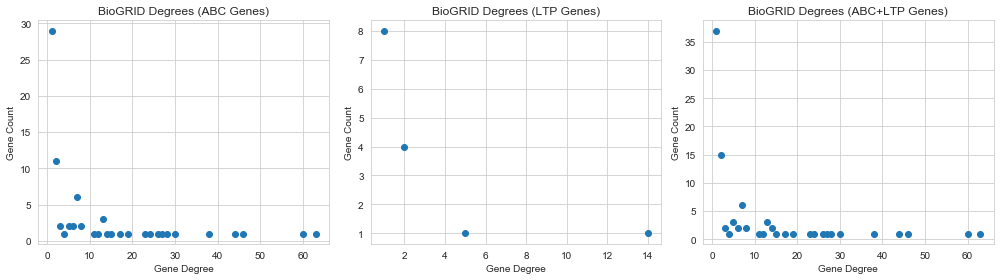

In [102]:
# Visualize degree distribution of BioGRID (psuedo bar plot)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.set_style('whitegrid')
sns.axes_style('ticks')
axs[0].scatter(deg_BABC,cnt_BABC)
axs[0].set_title('BioGRID Degrees (ABC Genes)')
axs[0].set_xlabel('Gene Degree')
axs[0].set_ylabel('Gene Count')
axs[1].scatter(deg_BLTP,cnt_BLTP)
axs[1].set_title('BioGRID Degrees (LTP Genes)')
axs[1].set_xlabel('Gene Degree')
axs[1].set_ylabel('Gene Count')
axs[2].scatter(deg_BB,cnt_BB)
axs[2].set_title('BioGRID Degrees (ABC+LTP Genes)')
axs[2].set_xlabel('Gene Degree')
axs[2].set_ylabel('Gene Count')
plt.tight_layout()

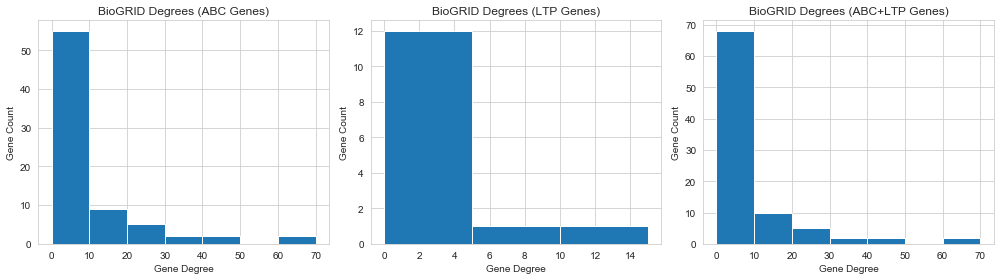

In [105]:
# Histogram Separated into 3 sections to see
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.set_style('whitegrid')
sns.axes_style('ticks')
axs[0].hist(deg_BioABC, bins = np.arange(0,71,10))
axs[0].set_title('BioGRID Degrees (ABC Genes)')
axs[0].set_xlabel('Gene Degree')
axs[0].set_ylabel('Gene Count')
axs[1].hist(deg_BioLTP, bins = np.arange(0,20,5))
axs[1].set_title('BioGRID Degrees (LTP Genes)')
axs[1].set_xlabel('Gene Degree')
axs[1].set_ylabel('Gene Count')
axs[2].hist(deg_BioB, bins = np.arange(0,71,10))
axs[2].set_title('BioGRID Degrees (ABC+LTP Genes)')
axs[2].set_xlabel('Gene Degree')
axs[2].set_ylabel('Gene Count')
plt.tight_layout()

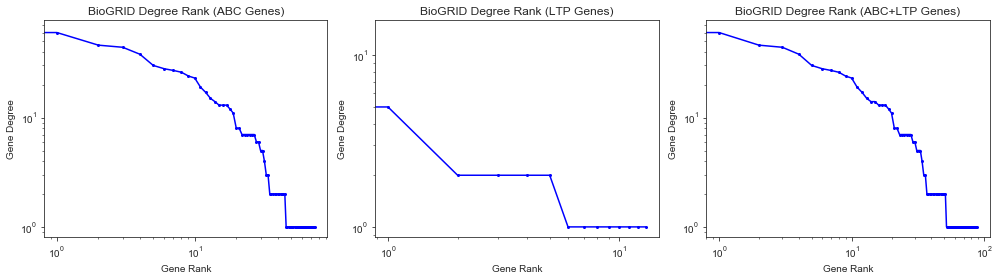

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.axes_style('ticks')
axs[0].loglog(rank_deg_bioABC, 'b-', marker='o', markersize = 2)
axs[0].set_title('BioGRID Degree Rank (ABC Genes)')
axs[0].set_xlabel('Gene Rank')
axs[0].set_ylabel('Gene Degree')
axs[1].loglog(rank_deg_bioLTP, 'b-', marker='o', markersize = 2)
axs[1].set_title('BioGRID Degree Rank (LTP Genes)')
axs[1].set_xlabel('Gene Rank')
axs[1].set_ylabel('Gene Degree')
axs[2].loglog(rank_deg_bioB, 'b-', marker='o', markersize = 2)
axs[2].set_title('BioGRID Degree Rank (ABC+LTP Genes)')
axs[2].set_xlabel('Gene Rank')
axs[2].set_ylabel('Gene Degree')
plt.tight_layout()